In [253]:
import os
import pandas as pd
import numpy as np
import re
import nltk

from tabulate import tabulate

from collections import Counter

from sklearn import metrics

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords


from sentence_transformers import SentenceTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


import pandas as pd
import numpy as np
from numpy.random import RandomState
rng = RandomState()

In [ ]:
def load_data():
    return pd.read_csv("data/fake.csv")


In [217]:
def summarize_data(input_df):
    print('Starting data analysis')

    print('dataset shape is')
    print(input_df.shape)

Starting data analysis


In [219]:
print('Columns Summary \n')

cols = []
for col in df.columns: 
    cols.append([ col, df[ col ].dtypes])
    
print(tabulate(cols, headers = [ 'column name', 'data type' ]))

Columns Summary 

column name         data type
------------------  -----------
uuid                object
ord_in_thread       int64
author              object
published           object
title               object
text                object
language            object
crawled             object
site_url            object
country             object
domain_rank         float64
thread_title        object
spam_score          float64
main_img_url        object
replies_count       int64
participants_count  int64
likes               int64
comments            int64
shares              int64
type                object


Column "type" value distribution

                 pct
bs          0.884068
bias        0.034080
conspiracy  0.033079
hate        0.018925
satire      0.011232
state       0.009308
junksci     0.007847
fake        0.001462
AxesSubplot(0.135,0.125;0.755x0.755)


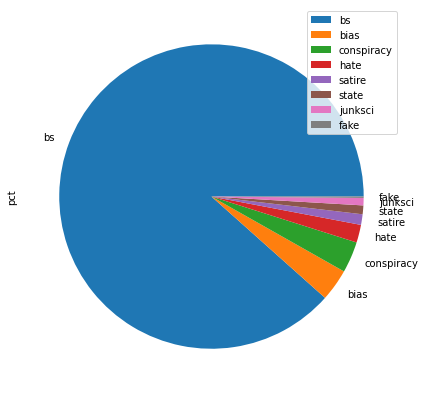

In [220]:
print('Column "type" value distribution\n')

vcp = df[ 'type' ].value_counts(normalize=True).to_frame('pct')
print(vcp)
print(vcp.plot.pie(y='pct', figsize=(7, 7)))

Column "language" value distribution

                 pct
english     0.954150
russian     0.015617
spanish     0.013232
german      0.008539
french      0.002923
arabic      0.001692
portuguese  0.000846
turkish     0.000769
italian     0.000692
ignore      0.000539
greek       0.000308
norwegian   0.000231
dutch       0.000231
chinese     0.000077
finnish     0.000077
polish      0.000077
AxesSubplot(0.135,0.125;0.755x0.755)


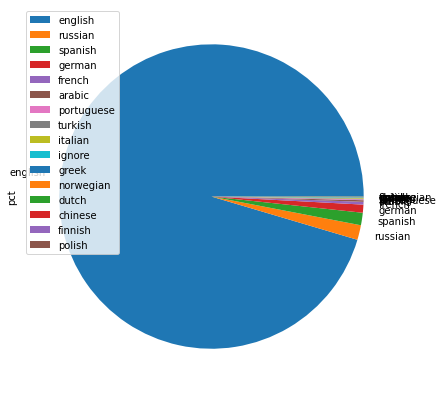

In [221]:
print('Column "language" value distribution\n')

vcp = df[ 'language' ].value_counts(normalize=True).to_frame('pct')
print(vcp)
print(vcp.plot.pie(y='pct', figsize=(7, 7)))

Start data cleaning
Selecting english

Column "language" value distribution english selection

         pct
english  1.0
AxesSubplot(0.135,0.125;0.755x0.755)


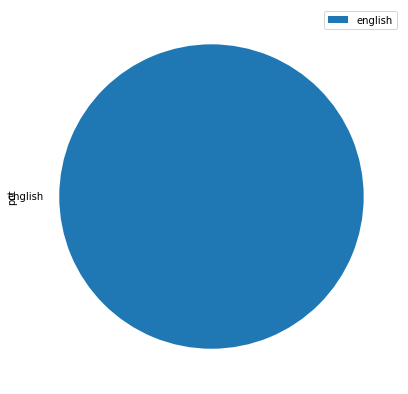

In [222]:
print('Start data cleaning')
print('Selecting english\n')
df = df[df.language == 'english']

print('Column "language" value distribution english selection\n')

vcp = df[ 'language' ].value_counts(normalize=True).to_frame('pct')
print(vcp)
print(vcp.plot.pie(y='pct', figsize=(7, 7)))

Column "type" value distribution after non-english exclusion

                 pct
bs          0.878820
bias        0.035717
conspiracy  0.034669
hate        0.019592
satire      0.011771
state       0.009675
junksci     0.008224
fake        0.001532
AxesSubplot(0.135,0.125;0.755x0.755)


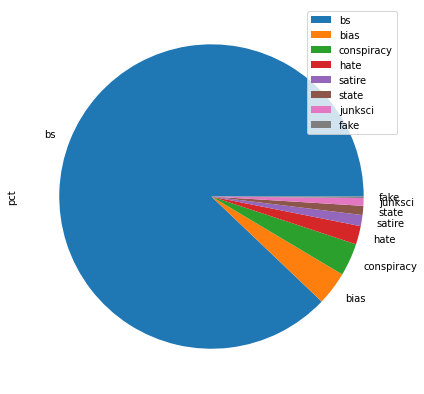

In [223]:
print('Column "type" value distribution after non-english exclusion\n')

vcp = df[ 'type' ].value_counts(normalize=True).to_frame('pct')
print(vcp)
print(vcp.plot.pie(y='pct', figsize=(7, 7)))

In [224]:
def getCleanData(df, force=False):
    # NOTICE: This takes several mins to run due to fillna
    
    print('Getting cleaned data')
    if not os.path.exists("caches/cleaned.csv") or force:
        print("start the cleaning process")
        
        print("Removing non-english records")
        df = df[df.language == 'english']
        
        cdf = pd.DataFrame()

        print("Fill missing values")
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        df.select_dtypes(include=numerics).fillna(df.mean())
        stop = stopwords.words('english')

        cdf['title'] = df['title'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))
        cdf['author'] = df['author'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))
        cdf['text'] = df['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))
        cdf['titles_word_len'] = cdf.apply(lambda row: len(nltk.word_tokenize(row['title'])), axis=1)
        cdf['author_word_len'] = cdf.apply(lambda row: len(nltk.word_tokenize(row['author'])), axis=1)
        cdf['text_word_len'] = cdf.apply(lambda row: len(nltk.word_tokenize(row['text'])), axis=1)

        cdf['ord_in_thread'] = df['ord_in_thread']
        cdf['spam_score'] = df['spam_score']
        cdf['replies_count'] = df['replies_count']
        cdf['participants_count'] = df['participants_count']
        cdf['likes'] = df['likes']
        cdf['comments'] = df['comments']
        cdf['shares'] = df['shares']
        cdf['country'] = df['country'].map(lambda x: list(df['country'].unique()).index(x))
        cdf['domain_rank'] = df['domain_rank'].fillna(0)
        cdf['site_url_length'] = df['site_url'].map(lambda x: len(str(x)))
        cdf['img_url_length'] = df['main_img_url'].map(lambda x: len(str(x)))
        cdf['wordpress'] = df['main_img_url'].map(lambda x: 1 if str(x).find('wp-content') >= 0 else 0)
        cdf['img_query'] = df['main_img_url'].map(lambda x: 1 if str(x).find('?') >= 0 else 0)
        cdf['target'] = df['type'].map(lambda x: 1 if x == 'bs' else 0)

#         print(cfd.head(100))
        cdf.to_csv("caches/cleaned.csv")
    else:
        print('cleaned.csv exsists, pull from cache')
    
    print('returning')
    return pd.read_csv("caches/cleaned.csv")

In [225]:
cleandf = getCleanData(df, force=False)
# cleandf.rename(columns = {'Unnamed: 0':'id'}, inplace = True)
cleandf = cleandf.drop('Unnamed: 0', axis=1)

print(cleandf['target'].value_counts())

Getting cleaned data
cleaned.csv exsists, pull from cache
returning
1    10900
0     1503
Name: target, dtype: int64


In [226]:
def split_x_y(df, target):
    try:
        y = df[ target ]
        X = df.drop(target, axis=1)
    except Exception as e:
        print('Error split_x_y')
        print (str(e))
    return X, y


In [227]:
# Under sample bc the dataset is wildly skewed

from imblearn.under_sampling import RandomUnderSampler

def resample(df):
    X, y = split_x_y(df, 'target')
    print('Original dataset shape %s' % Counter(y))

    under = RandomUnderSampler(sampling_strategy={1: 1503, 0: 1503})

    X_under_sample, y_under_sample = under.fit_resample(X, y)

    print('Resampled dataset shape %s' % Counter(y_under_sample))
    
    X_under_sample['target'] = y_under_sample
    
    return X_under_sample

cleandf = resample(cleandf)

print(cleandf.describe())
print(cleandf['target'].value_counts())

Original dataset shape Counter({1: 10900, 0: 1503})
Resampled dataset shape Counter({0: 1503, 1: 1503})
       titles_word_len  author_word_len  text_word_len  ord_in_thread  \
count      3006.000000      3006.000000    3006.000000    3006.000000   
mean         10.777112         1.823686     429.601131       1.190286   
std           5.913426         1.357123     576.485856       7.199537   
min           1.000000         1.000000       0.000000       0.000000   
25%           7.000000         1.000000     108.250000       0.000000   
50%          10.000000         2.000000     275.000000       0.000000   
75%          14.000000         2.000000     550.000000       0.000000   
max          75.000000        24.000000   11455.000000      98.000000   

        spam_score  replies_count  participants_count        likes  \
count  3006.000000    3006.000000         3006.000000  3006.000000   
mean      0.025473       1.853293            2.156021    25.946108   
std       0.126275       9.8

In [228]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Input: dataframe, field name, vector type [ count_vector || tfidf ]
# Output: dataframe
# Description: Inplace adds an encoding field for the passed field
def vectorize(input_df, field, vecType, top=10):
    text = input_df[ field ].values.astype('U')
    if vecType == 'count_vector':
        vectorizer = CountVectorizer(ngram_range = (3,4))
    elif vecType == 'tfidf':
        vectorizer = TfidfVectorizer(ngram_range = (3,4), stop_words='english')
    else:
        raise Exception("Type options: count_vector or tfifd") 

    vectorizer.fit(text)
    vector = vectorizer.transform(text)
    
    features = vectorizer.get_feature_names()
    scores = vector.toarray()
    sums = vector.sum(axis = 0)
    data1 = [] 
    for col, term in enumerate(features): 
        data1.append( (term, sums[0, col] )) 
    ranking = pd.DataFrame(data1, columns = ['term','rank']) 
    words = (ranking.sort_values('rank', ascending = False)) 

    name = field
    
    print ("\n\n Top "+str(top)+" "+name+" features : \n", words.head(top)) 

    input_df[ name ] = ''    
    input_df[ name ] = scores

    return input_df

In [252]:
def text_vectorize(input_df):
    vectorize(input_df, 'title', 'tfidf')
    vectorize(input_df, 'author', 'tfidf')
    vectorize(input_df, 'text', 'tfidf')

# TODO: Cache this

text_vectorize(cleandf)



ValueError: empty vocabulary; perhaps the documents only contain stop words

In [230]:
print(cleandf.shape)

(3006, 20)


In [231]:
print(cleandf.describe())

             title       author         text  titles_word_len  \
count  3006.000000  3006.000000  3006.000000      3006.000000   
mean      0.000100     0.000092     0.000010        10.777112   
std       0.005499     0.005059     0.000575         5.913426   
min       0.000000     0.000000     0.000000         1.000000   
25%       0.000000     0.000000     0.000000         7.000000   
50%       0.000000     0.000000     0.000000        10.000000   
75%       0.000000     0.000000     0.000000        14.000000   
max       0.301511     0.277350     0.031513        75.000000   

       author_word_len  text_word_len  ord_in_thread   spam_score  \
count      3006.000000    3006.000000    3006.000000  3006.000000   
mean          1.823686     429.601131       1.190286     0.025473   
std           1.357123     576.485856       7.199537     0.126275   
min           1.000000       0.000000       0.000000     0.000000   
25%           1.000000     108.250000       0.000000     0.000000   


In [232]:
print(cleandf[ 'target' ].value_counts())

1    1503
0    1503
Name: target, dtype: int64


AxesSubplot(0.125,0.125;0.62x0.755)


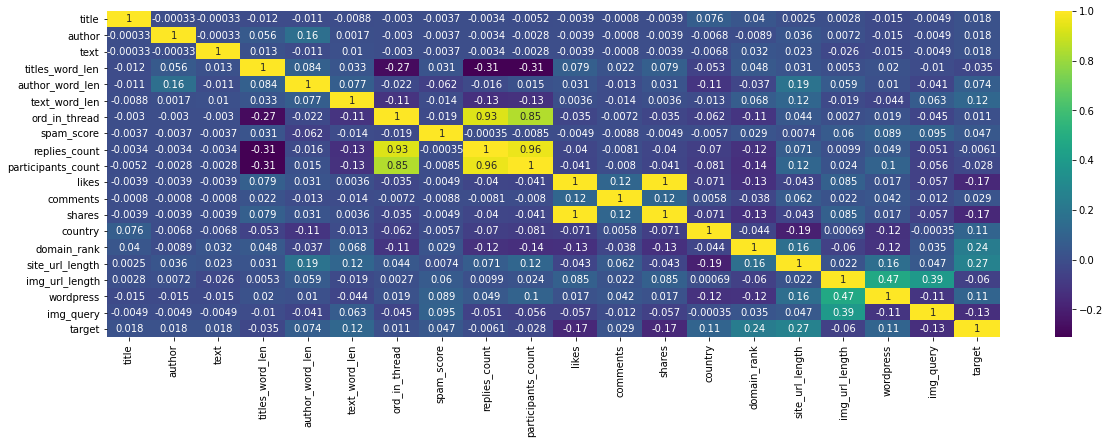

In [233]:
plt.figure(figsize=(20,6))
print(sns.heatmap(cleandf.corr(method='pearson'), annot=True, cmap = 'viridis'))

AxesSubplot(0.125,0.125;0.62x0.755)


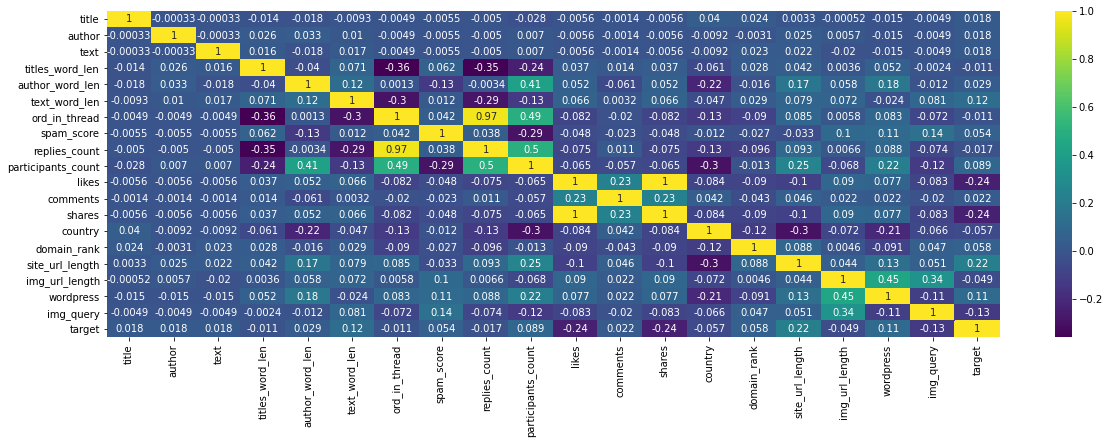

In [234]:

plt.figure(figsize=(20,6))
print(sns.heatmap(cleandf.corr(method='kendall'), annot=True, cmap = 'viridis'))

AxesSubplot(0.125,0.125;0.62x0.755)


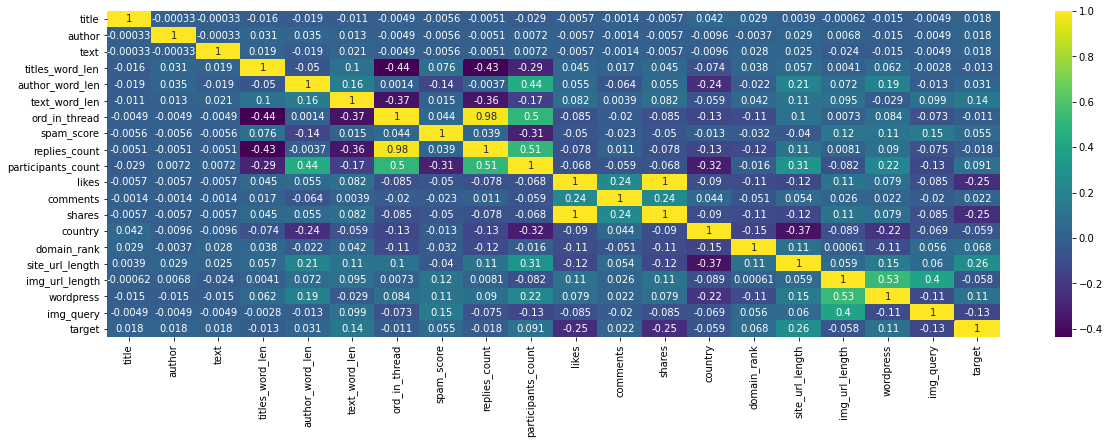

In [235]:

plt.figure(figsize=(20,6))


print(sns.heatmap(cleandf.corr(method='spearman'), annot=True, cmap = 'viridis'))

In [251]:
columns = ['domain_rank', 'site_url_length', 'img_url_length', 'wordpress',
       'img_query', 'target' ]
print(cleandf.columns)

print(cleandf['site_url_length'].value_counts())

selected = cleandf[ columns ]

Index(['title', 'author', 'text', 'titles_word_len', 'author_word_len',
       'text_word_len', 'ord_in_thread', 'spam_score', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'country',
       'domain_rank', 'site_url_length', 'img_url_length', 'wordpress',
       'img_query', 'target'],
      dtype='object')
16    525
13    383
17    283
11    261
15    218
12    174
18    164
19    162
21    152
7     131
10    115
14     77
20     72
25     53
22     45
24     41
8      40
23     35
9      26
30     25
29     20
27      2
6       2
Name: site_url_length, dtype: int64


In [237]:
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn import utils
from sklearn.feature_selection import chi2

def select_k_best_features(X, y, k=10):
    try:
        bestfeatures = SelectKBest(score_func=chi2, k='all')
        fit = bestfeatures.fit(X, y)
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(X.columns)

        featureScores = pd.concat([dfcolumns, dfscores], axis=1)
        featureScores.columns = ['Name','Score']
        print('Top '+str(k)+' features')
        print(featureScores.nlargest(k,'Score'))
        return X, y
    except Exception as e:
        print("error Feature Selection")
        print (str(e))

X, y = split_x_y(selected, 'target')        
        
X, y = select_k_best_features(X, y, 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


Top 100 features
              Name         Score
0      domain_rank  4.433229e+06
2   img_url_length  3.041333e+02
1  site_url_length  2.692502e+02
4        img_query  4.901961e+01
3        wordpress  2.072913e+01


In [238]:
# test_data = pd.DataFrame()

# test_data['titles_word_len'] = cleandf['titles_word_len']
# test_data['author_word_len'] = cleandf['author_word_len']
# test_data['text_word_len'] = cleandf['text_word_len']
# test_data['title_wo_stopwords'] = cleandf['title_wo_stopwords']
# test_data['author_wo_stopwords'] = cleandf['author_wo_stopwords']
# test_data['text_wo_stopwords'] = cleandf['text_wo_stopwords']
# test_data['site_url_length'] = cleandf['site_url_length']
# test_data['img_url_length'] = cleandf['img_url_length']



# y = cleandf[ "target" ]

# print(cleandf)



# print(X_train)
# print(X_test)
# print(Y_train.describe())
# print(Y_test)



In [239]:
# print('Train sentance embeddings')

# model = SentenceTransformer('bert-base-nli-mean-tokens')

# if not os.path.exists("X_train_under_embedds.npy"):
#     print("start build embedding training models")
#     X_trainL = X_train_under.values.tolist()
#     list_of_string = [''.join(str(element)) for element in X_trainL]
#     X_train_under_embedds = model.encode(list_of_string)
#     np.save('X_train_under_embedds.npy', X_train_under_embedds)
#     print("end build embedding training models")
# else:
#     X_train_under_embedds = np.load('X_train_under_embedds.npy')
    
# print(len(X_train_under_embedds))

# if not os.path.exists("X_test_embedds.npy"):
#     print("start build embedding testing models")
#     X_testL = X_test.values.tolist()
#     list_of_stringTest = [''.join(str(element)) for element in X_testL]
#     X_test_embedds = model.encode(list_of_stringTest)
#     print("end build embedding testing models")
#     np.save('X_test_embedds.npy', X_test_embedds)
# else:
#     X_test_embedds = np.load('X_test_embedds.npy')

# print(len(X_test_embedds))

In [240]:
# print(X_train_under)
# print(X_train_under_embedds)

In [241]:
def performance_info(classifier, Y_test, pred, name=False):
    print('\n\n classifier: '+name+'\n')
    if name == 'linear_regression':
        return
    
    score = metrics.accuracy_score(Y_test, pred,)
    print("accuracy:   %0.3f" % score)

    conf_mat_gnb = metrics.confusion_matrix(Y_test, pred)
#     print(conf_mat_gnb)

    disp = metrics.plot_confusion_matrix(classifier, X_test, y_test,
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(name)

    
    print('confusion matrix:\n', disp.confusion_matrix)

    print(metrics.classification_report(Y_test, pred, labels=np.unique(pred)))

In [242]:
import pickle

def build_model(model, X_train, y_train, X_test, y_test, save=False, name='test-save'):
    print('Building model '+name)
    print('Save '+str(save))
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    print(y_test.value_counts())
    
    performance_info(model, y_test, pred, name)
    
#     TODO: handle for save true but no or invalid name
    filename = 'models/'+name+'.pkl'
    
    pickle.dump(model, open(filename, 'wb'))
    
    print('Built model '+name)
    print("".join(["="]*50))
    return

# rf = RandomForestClassifier(max_depth = 100, min_samples_split=2, n_estimators = 500, random_state = 1)
# build_model(rf, X_train, y_train, True)

In [243]:
# Set up modeling functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

def random_forest(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Random Forest'
    print('Running '+name)
    try:
#         cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        random_forest = RandomForestClassifier(max_depth = 100, min_samples_split=2, n_estimators = 500, random_state = 1)
        results_randomforest = cross_val_score(random_forest, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_randomforest.mean())

        if build_model_ind:
            build_model(random_forest, X_train, y_train, X_test, y_test, True, name.replace(" ", "_").lower())

        return results_randomforest, random_forest
    except Exception as e:
        print('Error '+name)
        print (str(e))


from sklearn.naive_bayes import GaussianNB

def gaussian_naive_bayes(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
# def gaussian_naive_bayes(X, y, X_train=False, y_train=False):
    name = 'Gaussian Naive Bayes'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        gaussian = GaussianNB()
        results_gaussian = cross_val_score(gaussian, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_gaussian.mean())
        
        if build_model_ind:
            build_model(gaussian, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_gaussian, gaussian
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.svm import SVC

def support_vector_machines(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Support Vector Machines'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
#         svc = SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1, kernel='linear', max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)
        svc = SVC(kernel='rbf', gamma='auto')
        results_svc = cross_val_score(svc, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_svc.mean())

        if build_model_ind:
            build_model(svc, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_svc, svc
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.linear_model import LinearRegression

def linear_regression(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Linear Regression'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        lin_reg= LinearRegression()
        results_linreg= cross_val_score(lin_reg, X, y, cv=cv)
        print(name+' estimate accuracy',results_linreg.mean())

        if build_model_ind:
            build_model(lin_reg, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_linreg, lin_reg
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.linear_model import LogisticRegression

def logistic_regression(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Logistic Regression'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
        results_logreg = cross_val_score(logreg, X, y, cv=cv,scoring='accuracy')
        print(name+' estimate accuracy',results_logreg.mean())

        if build_model_ind:
            build_model(logreg, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_logreg, logreg
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.neighbors import KNeighborsClassifier

def KNN(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'KNN'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        knn = KNeighborsClassifier(n_neighbors = 3)
        results_knn = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_knn.mean())

        if build_model_ind:
            build_model(knn, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_knn, knn
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.linear_model import Perceptron

def perceptron(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Perceprton'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        perceptron = Perceptron(max_iter=1000, tol=1e-3)
        results_perceptron = cross_val_score(perceptron, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_perceptron.mean())

        if build_model_ind:
            build_model(perceptron, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_perceptron, perceptron
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis        

def linear_discriminant_analysis(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Linear Discriminant Analysis'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        clf = LinearDiscriminantAnalysis()
        results_clf = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_clf.mean())

        if build_model_ind:
            build_model(clf, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_clf, clf
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.ensemble import AdaBoostClassifier      

def ada_boost_classifier(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Ada Boost Classifier'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        AB = AdaBoostClassifier()
        results_AB = cross_val_score(AB, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_AB.mean())

        if build_model_ind:
            build_model(AB, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_AB, AB
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.ensemble import GradientBoostingClassifier        

def gradient_boosting_classifier(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Gradient Boosting Classifier'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        GBC = GradientBoostingClassifier()
        results_GBC = cross_val_score(GBC, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_GBC.mean())

        if build_model_ind:
            build_model(GBC, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_GBC, GBC
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from xgboost.sklearn import XGBClassifier

def XGB_classifier(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'XGBoost Classifier'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        xgbs = XGBClassifier(objective="binary:logistic", random_state=42)
        results_xgbs = cross_val_score(xgbs, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_xgbs.mean())

        if build_model_ind:
            build_model(xgbs, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_xgbs, xgbs
    except Exception as e:
        print('Error '+name)
        print (str(e))

In [244]:
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

def voting_ensemble_classification(X, y, cl_random_forest, cl_gaussian_naive_bayes, cl_support_vector_machines, cl_linear_regression, cl_logistic_regression, cl_knn, cl_perceptron, cl_linear_discriminant_analysis, cl_ada_boost_classifier, cl_gradient_boosting_classifier, cl_xgb_classifier):
    # missing 
        # cl_linear_regression
    try:
        seed = 7
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

        # create the sub models
        estimators = []

        estimators.append(('logistic', cl_logistic_regression))
        estimators.append(('svc', cl_support_vector_machines))
        estimators.append(('knn', cl_knn))
        estimators.append(('gaussian', cl_gaussian_naive_bayes))
        estimators.append(('perceptron', cl_perceptron))
#         estimators.append(('linearsvc', linearsvc))
#         estimators.append(('sgd', sgd))
#         estimators.append(('decisiontree', decisiontree))
        estimators.append(('randomforest', cl_random_forest))
        estimators.append(('clf', cl_linear_discriminant_analysis))
        estimators.append(('AB', cl_ada_boost_classifier))
        
        estimators.append(('GBC', cl_gradient_boosting_classifier))
#         estimators.append(('ETC', ETC))
        estimators.append(('xgbs', cl_xgb_classifier))

        # create the ensemble model
        ensemble = VotingClassifier(estimators, voting='hard')
        results_ensemble = model_selection.cross_val_score(ensemble, X, y, cv=kfold)
        print('Ensemble Acc: '+str(results_ensemble.mean()))
        return results_ensemble
    except Exception as e:
        print("error ensemble")
        print (str(e))


# 0.9860332225913622

# array([0.9833887 , 0.99003322, 0.98006645, 0.99335548, 0.98006645,
#        0.97342193, 0.98333333, 0.99333333, 0.99      , 0.99333333])

In [245]:
def model_evaluation(results_ensemble, results_random_forest, results_gaussian_naive_bayes, results_support_vector_machines, results_linear_regression, results_logistic_regression, results_KNN, results_perceptron, results_linear_discriminant_analysis, results_ada_boost_classifier, results_gradient_boosting_classifier, results_XGB_classifier):
    try:
        #Model evaluation
        print("Model evaluation")
        models = pd.DataFrame({
        'Model': ['ensemble', 'random forest', 'gaussian naive bayes', 'support vector machines', 'linear regression', 'logistic regression', 'KNN', 'perceptron', 'linear discriminant analysis', 'ada boost classifier', 'gradient boosting classifier', 'XGB classifie',],
        'Score': [
            results_ensemble.mean(),
            results_random_forest.mean(),
            results_gaussian_naive_bayes.mean(),
            results_support_vector_machines.mean(),
            results_linear_regression.mean(),
            results_logistic_regression.mean(),
            results_KNN.mean(),
            results_perceptron.mean(),
            results_linear_discriminant_analysis.mean(),
            results_ada_boost_classifier.mean(),
            results_gradient_boosting_classifier.mean(),
            results_XGB_classifier.mean()
        ]})
        print(models.sort_values(by='Score', ascending=False))
        #Model score
    except Exception as e:
        print("error Model evaluation")
        print (str(e))

# Model evaluation
#                            Model     Score
# 10                 XGB classifie  0.996673
# 0                  random forest  0.996341
# 9   gradient boosting classifier  0.993014
# 5                            KNN  0.989024
# 8           ada boost classifier  0.965403
# 7   linear discriminant analysis  0.719553
# 1           gaussian naive bayes  0.667981
# 4            logistic regression  0.655364
# 2        support vector machines  0.644699
# 6                     perceptron  0.539938
# 3              linear regression  0.225436


Run classifications
Running Random Forest
Random Forest estimate accuracy 0.9880299003322259
Building model random_forest
Save True
0    388
1    364
Name: target, dtype: int64


 classifier: random_forest

accuracy:   0.989
confusion matrix:
 [[381   7]
 [  1 363]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       388
           1       0.98      1.00      0.99       364

    accuracy                           0.99       752
   macro avg       0.99      0.99      0.99       752
weighted avg       0.99      0.99      0.99       752

Built model random_forest
Running Gaussian Naive Bayes
Gaussian Naive Bayes estimate accuracy 0.6344031007751939
Building model gaussian_naive_bayes
Save True
0    388
1    364
Name: target, dtype: int64


 classifier: gaussian_naive_bayes

accuracy:   0.665
confusion matrix:
 [[301  87]
 [165 199]]
              precision    recall  f1-score   support

           0       0.65      0.78      0.70       

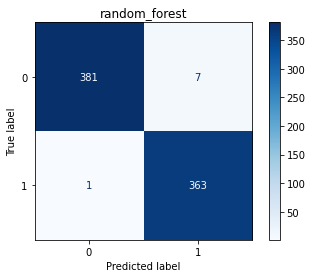

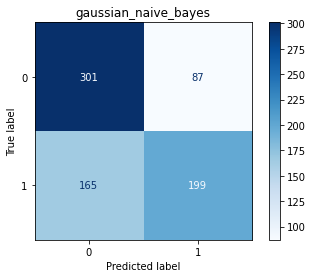

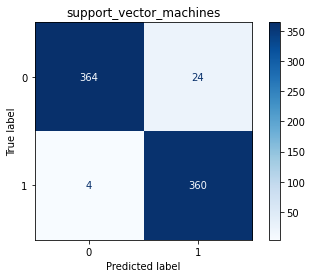

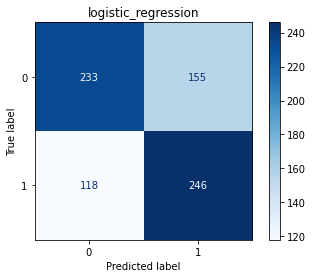

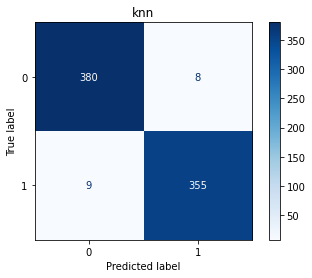

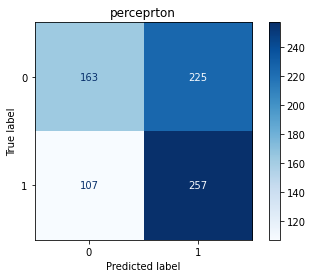

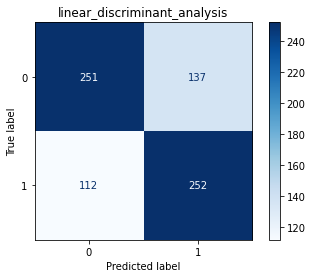

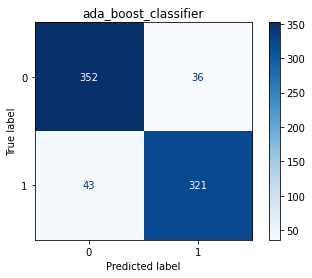

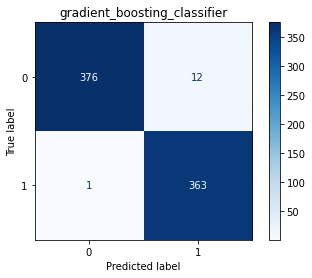

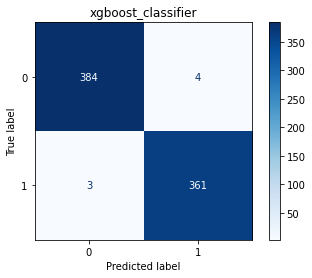

In [246]:
print('Run classifications')

results_random_forest, cl_random_forest = random_forest(X, y, X_train, y_train, X_test, y_test, True, True)
results_gaussian_naive_bayes, cl_gaussian_naive_bayes = gaussian_naive_bayes(X, y, X_train, y_train, X_test, y_test, True, True)
results_support_vector_machines, cl_support_vector_machines = support_vector_machines(X, y, X_train, y_train, X_test, y_test, True, True)
results_linear_regression, cl_linear_regression = linear_regression(X, y, X_train, y_train, X_test, y_test, True, True)
results_logistic_regression, cl_logistic_regression = logistic_regression(X, y, X_train, y_train, X_test, y_test, True, True)
results_KNN, cl_knn = KNN(X, y, X_train, y_train, X_test, y_test, True, True)
results_perceptron, cl_perceptron = perceptron(X, y, X_train, y_train, X_test, y_test, True, True)
results_linear_discriminant_analysis, cl_linear_discriminant_analysis = linear_discriminant_analysis(X, y, X_train, y_train, X_test, y_test, True, True)
results_ada_boost_classifier, cl_ada_boost_classifier = ada_boost_classifier(X, y, X_train, y_train, X_test, y_test, True, True)
results_gradient_boosting_classifier, cl_gradient_boosting_classifier = gradient_boosting_classifier(X, y, X_train, y_train, X_test, y_test, True, True)
results_XGB_classifier, cl_xgb_classifier = XGB_classifier(X, y, X_train, y_train, X_test, y_test, True, True)

results_ensemble = voting_ensemble_classification(X, y, cl_random_forest, cl_gaussian_naive_bayes, cl_support_vector_machines, cl_linear_regression, cl_logistic_regression, cl_knn, cl_perceptron, cl_linear_discriminant_analysis, cl_ada_boost_classifier, cl_gradient_boosting_classifier, cl_xgb_classifier)

model_evaluation(results_ensemble, results_random_forest, results_gaussian_naive_bayes, results_support_vector_machines, results_linear_regression, results_logistic_regression, results_KNN, results_perceptron, results_linear_discriminant_analysis, results_ada_boost_classifier, results_gradient_boosting_classifier, results_XGB_classifier)

# results_random_forest, cl_random_forest = random_forest(X, y)
# results_gaussian_naive_bayes, cl_gaussian_naive_bayes = gaussian_naive_bayes(X, y)
# results_support_vector_machines, cl_support_vector_machines = support_vector_machines(X, y)
# results_linear_regression, cl_linear_regression = linear_regression(X, y)
# results_logistic_regression, cl_logistic_regression = logistic_regression(X, y)
# results_KNN, cl_knn = KNN(X, y)
# results_perceptron, cl_perceptron = perceptron(X, y)
# results_linear_discriminant_analysis, cl_linear_discriminant_analysis = linear_discriminant_analysis(X, y)
# results_ada_boost_classifier, cl_ada_boost_classifier = ada_boost_classifier(X, y)
# results_gradient_boosting_classifier, cl_gradient_boosting_classifier = gradient_boosting_classifier(X, y)
# results_XGB_classifier, cl_xgb_classifier = XGB_classifier(X, y)

# initial
# Run classifications
# Running Random Forest
# Random Forest estimate accuracy 0.9604392317198528
# Running Gaussian Naive Bayes
# Gaussian Naive Bayes estimate accuracy 0.8711027568922306
# Running Support Vector Machines
# Support Vector Machines estimate accuracy 0.9013115738655394
# Running Linear Regression
# Linear Regression estimate accuracy 0.03227553195292534
# Running Logistic Regression
# Logistic Regression estimate accuracy 0.879164385618424
# Running KNN
# KNN estimate accuracy 0.8858305903006365
# Running Perceprton
# Perceprton estimate accuracy 0.7318553295681601
# Running Linear Discriminant Analysis
# Linear Discriminant Analysis estimate accuracy 0.879164385618424
# Running Ada Boost Classifier
# Ada Boost Classifier estimate accuracy 0.8795943776491921
# Running Gradient Boosting Classifier
# Gradient Boosting Classifier estimate accuracy 0.9253920515574651
# Running XGBoost Classifier
# XGBoost Classifier estimate accuracy 0.9594725292493906


# all features w/ y
# Run classifications
# Running Random Forest
# Random Forest estimate accuracy 0.9963410852713178
# Running Gaussian Naive Bayes
# Gaussian Naive Bayes estimate accuracy 0.6679811738648948
# Running Support Vector Machines
# Support Vector Machines estimate accuracy 0.6446987818383166
# Running Linear Regression
# Linear Regression estimate accuracy 0.2254357223925374
# Running Logistic Regression
# Logistic Regression estimate accuracy 0.6553643410852712
# Running KNN
# KNN estimate accuracy 0.9890243632336656
# Running Perceprton
# Perceprton estimate accuracy 0.5399379844961241
# Running Linear Discriminant Analysis
# Linear Discriminant Analysis estimate accuracy 0.7195526024363232
# Running Ada Boost Classifier
# Ada Boost Classifier estimate accuracy 0.9654031007751938
# Running Gradient Boosting Classifier
# Gradient Boosting Classifier estimate accuracy 0.9933466223698781
# Running XGBoost Classifier
# XGBoost Classifier estimate accuracy 0.9966733111849392



In [247]:
df = load_data()

